In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
import matplotlib.pyplot as plt
# import matplotlib.image as img
import IPython
from IPython.display import display
import tensorflow_addons as tfa
from PIL import Image
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, UpSampling2D, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from matplotlib.pyplot import imshow

from kaggle_datasets import KaggleDatasets

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
train = pathlib.Path("../input/div2k/DIV2K_train_HR/DIV2K_train_HR").glob("*.png")
validate = pathlib.Path("../input/div2k/DIV2K_valid_HR/DIV2K_valid_HR").glob("*.png")
training_sorted = sorted([x for x in train])

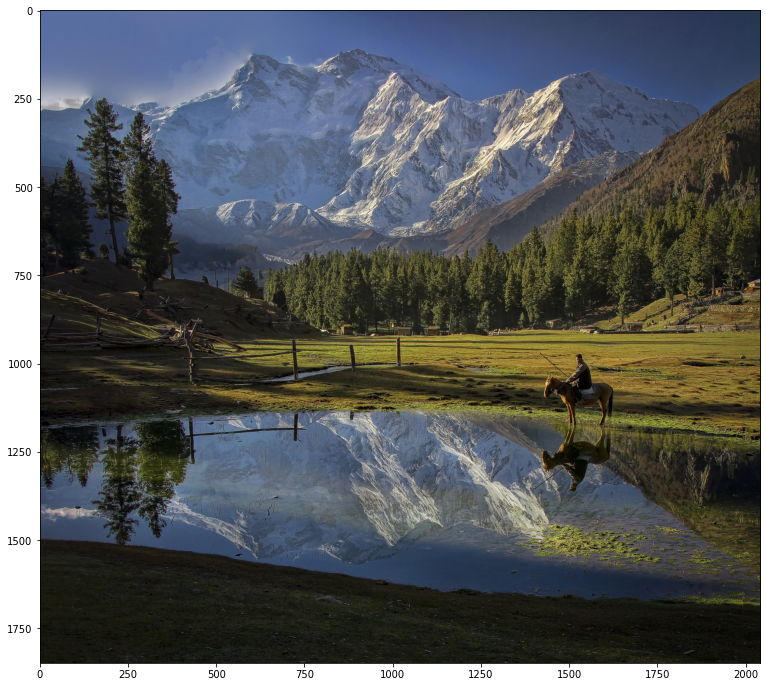

In [3]:
path=str(training_sorted[1])
image=Image.open(path)
plt.figure(figsize=(24, 12))
plt.imshow(image)

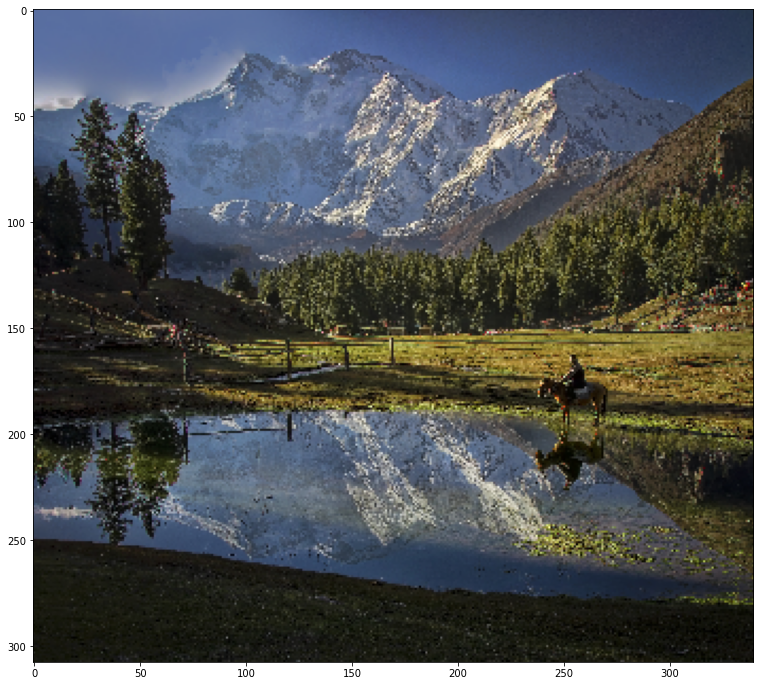

In [4]:
plt.figure(figsize=(24,12))
plt.imshow(np.array(image)[::6,::6,:])
# 800*1080*1080*3
# x * 1080 * 1080 * 

In [5]:
import tensorflow_datasets as tfds
(ds_train, ds_test), ds_info = tfds.load('div2k', split=['train', 'validation'],
                                    with_info=True, as_supervised=True)

2022-11-30 12:23:44.763068: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 12:23:44.764007: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 12:23:45.019217: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 12:23:45.020133: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 12:23:45.021134: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [6]:
ds_train.take(1)

<TakeDataset shapes: ((None, None, 3), (None, None, 3)), types: (tf.uint8, tf.uint8)>

In [7]:
ds_info

tfds.core.DatasetInfo(
    name='div2k',
    full_name='div2k/bicubic_x2/2.0.0',
    description="""
    DIV2K dataset: DIVerse 2K resolution high quality images as used for the challenges @ NTIRE (CVPR 2017 and CVPR 2018) and @ PIRM (ECCV 2018)
    """,
    config_description="""
    Uses bicubic_x2 data.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/DIV2K/',
    data_path='/root/tensorflow_datasets/div2k/bicubic_x2/2.0.0',
    download_size=4.68 GiB,
    dataset_size=4.68 GiB,
    features=FeaturesDict({
        'hr': Image(shape=(None, None, 3), dtype=tf.uint8),
        'lr': Image(shape=(None, None, 3), dtype=tf.uint8),
    }),
    supervised_keys=('lr', 'hr'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=800, num_shards=64>,
        'validation': <SplitInfo num_examples=100, num_shards=8>,
    },
    citation="""@InProceedings{Agustsson_2017_CVPR_Workshops,
    	author = {Agustsson, Eirikur and Timofte, Radu},
    	title = {NTIRE 2

In [8]:
# tfds.show_examples(dTrain,ds_info, image_key='hr', rows=1,cols=1)

In [9]:
# plt.figure(figsize=(10,10))
# tfds.show_examples(dTrain,ds_info, image_key='lr', rows=1,cols=1)

2022-11-30 12:23:50.375541: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
Cleanup called...
Cleanup called...


(678, 1020, 3) (1356, 2040, 3)
##################################################


Cleanup called...
Cleanup called...


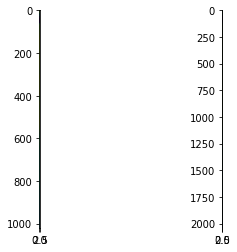

In [10]:
# # ds = tfds.load('mnist', split='train')
# ds=dTrain
# ds = ds.take(5)  # Only take a single example

for i,xyz in enumerate(ds_train.take(1)):  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    print(xyz[0].shape, xyz[1].shape)
    hri = xyz[0][i]
    lri = xyz[1][i]
    ax=plt.subplot(1,2,1)
    ax.imshow(hri)
#     plt.show()
    
    ax=plt.subplot(1,2,2)
    ax.imshow(lri)
#     plt.show()
    print('#'*50)


In [11]:
# from tensorflow.python.framework.ops import disable_eager_execution

# disable_eager_execution()

def downsample(x, scale = 2):
    y = x[:, ::scale, ::scale, :]
    return y

def upsample(x, scale = 2):
    y = tf.keras.layers.UpSampling2D(size = scale, interpolation='bilinear')(x)
#     y = tf.cast(y, dtype = tf.int32)
    return y

def fusion_layer(arr_of_img, filters = 32, scaling = 0, kernel_sz = 3):
    x = tf.concat(arr_of_img, axis = 3)
    x = Conv2D(filters, kernel_sz, padding = 'same')(x)
    return x

def conv_block(input_image, filters = 32, scaling = 0, kernel_sz = 3):
    x = Conv2D(filters, kernel_sz, padding='same', activation='relu')(input_image)
    x = Conv2D(filters, kernel_sz, padding='same')(x)
    if scaling:
        x = Lambda(lambda t: t * scaling)(x)
    x = Add()([input_image, x])
    return x

def RLA_block(input_img, filters = 32, kernel_sz = 3):
    output_1 = conv_block(input_img)
    output_2 = conv_block(output_1)
    output_3 = conv_block(output_2)
    output_4 = fusion_layer([output_1, output_2, output_3])
    final_output = Add()([output_4, input_img])
    return final_output
    
def HFP_block(input_img):
    d_output = downsample(input_img)
    up_output = upsample(d_output)
    org_img = input_img
    org_img = Add()([org_img, -up_output])
    return org_img

def PRB_block(input_img):
    x = RLA_block(input_img)
    y = HFP_block(x)
    p = downsample(x)
    q = RLA_block(p)
    r = downsample(q)
    w = HFP_block(q)
    r = RLA_block(r)
    r = upsample(r)
    w = Add()([w,r])
    q = fusion_layer([q,w])
    q = RLA_block(q)
    z = upsample(q)
    y = Add()([y, z])
    x = fusion_layer([x,y])
    x = RLA_block(x)
    return x

def pixel_shuffle_block(input_img, filters = 32, kernel_sz = 3):
    x = Conv2D(filters, kernel_sz, padding = 'same')(input_img)
    x = tf.nn.depth_to_space(x, block_size = 2)
    x = Conv2D(3, kernel_sz, padding = 'same')(x)
    return x

def deep_extraction_block(input_img, n = 3, filters = 32, kernel_sz = 3):
    prb_block_outputs = [input_img]
    x = input_img
    for _ in range(n):
        x = PRB_block(x)
        prb_block_outputs.append(x)
    y = fusion_layer(prb_block_outputs)
    return y

def reconstruction_block(input_img, filters = 32, kernel_sz = 3):
    x = Conv2D(filters, kernel_sz, padding = 'same')(input_img)
    x = deep_extraction_block(x)
    x = pixel_shuffle_block(x)
    y = pixel_shuffle_block(input_img)
    x = Add()([x,y])
    return x

def get_model(input_shape = (None,None,3)):
    inputs = tf.keras.layers.Input(input_shape)
    temp = tf.keras.layers.Rescaling(scale = 1.00/255.00)(inputs)
    outputs = reconstruction_block(temp)
    x = Model(inputs, outputs)
    return x

res_model = get_model()
res_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 896         rescaling[0][0]                  
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 9248        conv2d[0][0]                     
______________________________________________________________________________________________

In [12]:
# a = np.array(Image.open('../input/div2k/DIV2K_train_HR/DIV2K_train_HR/0001.png'))
# plt.imshow(a); plt.show()
# y = tf.keras.layers.UpSampling2D(size = (2,2), interpolation='bilinear')(np.array([a]))
# y = np.array(y).astype(np.int)
# plt.imshow(y[0]); plt.show()

In [13]:
smooth = 100
epsilon = 1e-5
EPOCHS = 20
learning_rate = 2e-4
decay_rate = learning_rate / EPOCHS
batch_size = 8

def resize_dataset(inp, out):
    input_shape=[300,300]
    output_shape=[600,600]
    inp = tf.image.resize(inp, input_shape)
    out = tf.image.resize(out, output_shape)
    return inp, out

def rescale(inp, out):
    pass

Autotune = tf.data.experimental.AUTOTUNE
ds_train = ds_train.map(resize_dataset,num_parallel_calls=Autotune).cache().batch(2).prefetch(Autotune)
ds_test = ds_test.map(resize_dataset,num_parallel_calls=Autotune).batch(2).prefetch(Autotune)


def ssim(y_true, y_pred):
    z = tf.image.ssim_multiscale(y_true, y_pred, max_val = 255)
    return z

def psnr(y_true, y_pred):
    psnr = tf.image.psnr(y_true, y_pred, max_val = 255)
    return psnr

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
res_model.compile(optimizer = opt, loss = tf.keras.losses.MeanAbsoluteError(), metrics=[psnr,ssim])
callbacks = [tf.keras.callbacks.ModelCheckpoint('model.h5', verbose=1, save_best_only=True),
            tf.keras.callbacks.CSVLogger('model_history.csv', append=False),
            tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0.0001,
                              mode='min', 
                              verbose=1, 
                              patience=20,
                              restore_best_weights = True
                             ),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patence=10,
                              min_delta=0.0001,
                              factor=0.2
                             )]

In [14]:
ds_train.take(1)

<TakeDataset shapes: ((None, 300, 300, 3), (None, 600, 600, 3)), types: (tf.float32, tf.float32)>

In [15]:
history = res_model.fit(ds_train, epochs=EPOCHS, callbacks=callbacks, validation_data = ds_test)

Epoch 1/20


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
2022-11-30 12:24:19.190922: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


  1/400 [..............................] - ETA: 2:50:08 - loss: 2958.6418 - psnr: -22.9779 - ssim: 0.0036

Cleanup called...
Cleanup called...


  2/400 [..............................] - ETA: 2:30 - loss: 1893.9033 - psnr: -17.6398 - ssim: 0.0045   

Cleanup called...
Cleanup called...
Cleanup called...


  3/400 [..............................] - ETA: 2:32 - loss: 1953.2533 - psnr: -18.6483 - ssim: 0.0057

Cleanup called...
Cleanup called...


  4/400 [..............................] - ETA: 2:30 - loss: 1717.7451 - psnr: -17.5661 - ssim: 0.0068

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  5/400 [..............................] - ETA: 2:30 - loss: 1538.7546 - psnr: -16.4185 - ssim: 0.0112

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  6/400 [..............................] - ETA: 2:29 - loss: 1322.3467 - psnr: -13.9576 - ssim: 0.0094

Cleanup called...
Cleanup called...
Cleanup called...


  7/400 [..............................] - ETA: 2:29 - loss: 1176.4385 - psnr: -12.4621 - ssim: 0.0126

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  8/400 [..............................] - ETA: 2:29 - loss: 1057.3965 - psnr: -11.0364 - ssim: 0.0207

Cleanup called...
Cleanup called...


  9/400 [..............................] - ETA: 2:29 - loss: 963.4277 - psnr: -9.8837 - ssim: 0.0221  

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 10/400 [..............................] - ETA: 2:28 - loss: 884.6901 - psnr: -8.7921 - ssim: 0.0267

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 11/400 [..............................] - ETA: 2:28 - loss: 821.3250 - psnr: -7.8776 - ssim: 0.0374

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 12/400 [..............................] - ETA: 2:27 - loss: 769.4983 - psnr: -7.2057 - ssim: 0.0404

Cleanup called...
Cleanup called...
Cleanup called...


 13/400 [..............................] - ETA: 2:27 - loss: 721.1638 - psnr: -6.4177 - ssim: 0.0432

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 14/400 [>.............................] - ETA: 2:26 - loss: 679.3941 - psnr: -5.7213 - ssim: 0.0432

Cleanup called...
Cleanup called...
Cleanup called...


 15/400 [>.............................] - ETA: 2:26 - loss: 643.6342 - psnr: -5.1676 - ssim: 0.0469

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 16/400 [>.............................] - ETA: 2:26 - loss: 613.6821 - psnr: -4.7426 - ssim: 0.0487

Cleanup called...
Cleanup called...
Cleanup called...


 17/400 [>.............................] - ETA: 2:26 - loss: 584.1577 - psnr: -4.1590 - ssim: 0.0526

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 18/400 [>.............................] - ETA: 2:25 - loss: 559.3071 - psnr: -3.7499 - ssim: 0.0558

Cleanup called...
Cleanup called...
Cleanup called...


 19/400 [>.............................] - ETA: 2:25 - loss: 534.6602 - psnr: -3.2334 - ssim: 0.0629

Cleanup called...
Cleanup called...
Cleanup called...


 20/400 [>.............................] - ETA: 2:24 - loss: 513.8063 - psnr: -2.8519 - ssim: 0.0646

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 21/400 [>.............................] - ETA: 2:24 - loss: 494.5429 - psnr: -2.4660 - ssim: 0.0679

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 22/400 [>.............................] - ETA: 2:23 - loss: 477.0288 - psnr: -2.1179 - ssim: 0.0690

Cleanup called...
Cleanup called...
Cleanup called...


 23/400 [>.............................] - ETA: 2:23 - loss: 459.3387 - psnr: -1.6179 - ssim: 0.0735

Cleanup called...
Cleanup called...
Cleanup called...


 24/400 [>.............................] - ETA: 2:22 - loss: 443.4698 - psnr: -1.2334 - ssim: 0.0780

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 25/400 [>.............................] - ETA: 2:22 - loss: 429.2966 - psnr: -0.9070 - ssim: 0.0798

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 26/400 [>.............................] - ETA: 2:22 - loss: 415.2007 - psnr: -0.4989 - ssim: 0.0888

Cleanup called...
Cleanup called...
Cleanup called...


 27/400 [=>............................] - ETA: 2:21 - loss: 403.0220 - psnr: -0.2075 - ssim: 0.0899

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 28/400 [=>............................] - ETA: 2:21 - loss: 392.5566 - psnr: -0.0159 - ssim: 0.0898

Cleanup called...
Cleanup called...
Cleanup called...


 29/400 [=>............................] - ETA: 2:21 - loss: 381.7489 - psnr: 0.2736 - ssim: 0.0995 

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 30/400 [=>............................] - ETA: 2:20 - loss: 371.6851 - psnr: 0.5231 - ssim: 0.1056

Cleanup called...
Cleanup called...
Cleanup called...


 31/400 [=>............................] - ETA: 2:20 - loss: 362.0424 - psnr: 0.7894 - ssim: 0.1087

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 32/400 [=>............................] - ETA: 2:19 - loss: 353.8501 - psnr: 0.9556 - ssim: 0.1136

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 33/400 [=>............................] - ETA: 2:19 - loss: 345.8770 - psnr: 1.1415 - ssim: 0.1191

Cleanup called...
Cleanup called...
Cleanup called...


 34/400 [=>............................] - ETA: 2:18 - loss: 338.1960 - psnr: 1.3295 - ssim: 0.1193

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 35/400 [=>............................] - ETA: 2:18 - loss: 331.2936 - psnr: 1.4795 - ssim: 0.1243

Cleanup called...
Cleanup called...
Cleanup called...


 36/400 [=>............................] - ETA: 2:18 - loss: 324.2682 - psnr: 1.6651 - ssim: 0.1274

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 37/400 [=>............................] - ETA: 2:17 - loss: 317.1162 - psnr: 1.8914 - ssim: 0.1310

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 38/400 [=>............................] - ETA: 2:17 - loss: 310.4501 - psnr: 2.0959 - ssim: 0.1333

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 39/400 [=>............................] - ETA: 2:17 - loss: 304.3579 - psnr: 2.2688 - ssim: 0.1359

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 40/400 [==>...........................] - ETA: 2:16 - loss: 297.9705 - psnr: 2.5138 - ssim: 0.1428

Cleanup called...
Cleanup called...
Cleanup called...


 41/400 [==>...........................] - ETA: 2:16 - loss: 292.4066 - psnr: 2.6747 - ssim: 0.1459

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 42/400 [==>...........................] - ETA: 2:16 - loss: 286.9365 - psnr: 2.8482 - ssim: 0.1483

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 43/400 [==>...........................] - ETA: 2:15 - loss: 281.5233 - psnr: 3.0413 - ssim: 0.1527

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 44/400 [==>...........................] - ETA: 2:15 - loss: 276.2583 - psnr: 3.2287 - ssim: 0.1589

Cleanup called...
Cleanup called...
Cleanup called...


 45/400 [==>...........................] - ETA: 2:14 - loss: 271.0404 - psnr: 3.4503 - ssim: 0.1647

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 46/400 [==>...........................] - ETA: 2:14 - loss: 266.0951 - psnr: 3.6536 - ssim: 0.1710

Cleanup called...
Cleanup called...
Cleanup called...


 47/400 [==>...........................] - ETA: 2:14 - loss: 261.6028 - psnr: 3.8081 - ssim: 0.1748

Cleanup called...
Cleanup called...
Cleanup called...


 48/400 [==>...........................] - ETA: 2:14 - loss: 257.4190 - psnr: 3.9462 - ssim: 0.1776

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 49/400 [==>...........................] - ETA: 2:13 - loss: 253.3659 - psnr: 4.0816 - ssim: 0.1782

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 50/400 [==>...........................] - ETA: 2:13 - loss: 249.0624 - psnr: 4.2966 - ssim: 0.1841

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 51/400 [==>...........................] - ETA: 2:12 - loss: 245.3472 - psnr: 4.4138 - ssim: 0.1871

Cleanup called...
Cleanup called...
Cleanup called...


 52/400 [==>...........................] - ETA: 2:12 - loss: 241.5882 - psnr: 4.5634 - ssim: 0.1901

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 53/400 [==>...........................] - ETA: 2:12 - loss: 237.9793 - psnr: 4.7010 - ssim: 0.1922

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 54/400 [===>..........................] - ETA: 2:12 - loss: 234.4458 - psnr: 4.8397 - ssim: 0.1958

Cleanup called...
Cleanup called...
Cleanup called...


 55/400 [===>..........................] - ETA: 2:11 - loss: 231.0769 - psnr: 4.9737 - ssim: 0.1969

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 56/400 [===>..........................] - ETA: 2:11 - loss: 227.7793 - psnr: 5.1044 - ssim: 0.1999

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 57/400 [===>..........................] - ETA: 2:11 - loss: 224.6869 - psnr: 5.2209 - ssim: 0.2000

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 58/400 [===>..........................] - ETA: 2:10 - loss: 221.5683 - psnr: 5.3536 - ssim: 0.2036

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 59/400 [===>..........................] - ETA: 2:10 - loss: 218.5946 - psnr: 5.4691 - ssim: 0.2074

Cleanup called...
Cleanup called...
Cleanup called...


 60/400 [===>..........................] - ETA: 2:10 - loss: 215.7595 - psnr: 5.5815 - ssim: 0.2081

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 61/400 [===>..........................] - ETA: 2:09 - loss: 213.0081 - psnr: 5.6909 - ssim: 0.2109

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 62/400 [===>..........................] - ETA: 2:09 - loss: 210.2055 - psnr: 5.8222 - ssim: 0.2153

Cleanup called...
Cleanup called...


 63/400 [===>..........................] - ETA: 2:08 - loss: 207.3986 - psnr: 5.9658 - ssim: 0.2198

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 64/400 [===>..........................] - ETA: 2:08 - loss: 204.8852 - psnr: 6.0716 - ssim: 0.2208

Cleanup called...
Cleanup called...
Cleanup called...


 65/400 [===>..........................] - ETA: 2:08 - loss: 202.4748 - psnr: 6.1671 - ssim: 0.2230

Cleanup called...
Cleanup called...
Cleanup called...


 66/400 [===>..........................] - ETA: 2:07 - loss: 199.9255 - psnr: 6.2924 - ssim: 0.2271

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 67/400 [====>.........................] - ETA: 2:07 - loss: 197.7130 - psnr: 6.3797 - ssim: 0.2289

Cleanup called...
Cleanup called...
Cleanup called...


 68/400 [====>.........................] - ETA: 2:07 - loss: 195.5529 - psnr: 6.4589 - ssim: 0.2317

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 69/400 [====>.........................] - ETA: 2:06 - loss: 193.2758 - psnr: 6.5688 - ssim: 0.2347

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 70/400 [====>.........................] - ETA: 2:06 - loss: 191.2436 - psnr: 6.6466 - ssim: 0.2361

Cleanup called...
Cleanup called...
Cleanup called...


 71/400 [====>.........................] - ETA: 2:05 - loss: 189.1550 - psnr: 6.7406 - ssim: 0.2385

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 72/400 [====>.........................] - ETA: 2:05 - loss: 187.1371 - psnr: 6.8257 - ssim: 0.2385

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 73/400 [====>.........................] - ETA: 2:05 - loss: 185.2393 - psnr: 6.9017 - ssim: 0.2415

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 74/400 [====>.........................] - ETA: 2:04 - loss: 183.4249 - psnr: 6.9696 - ssim: 0.2447

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 75/400 [====>.........................] - ETA: 2:04 - loss: 181.6637 - psnr: 7.0332 - ssim: 0.2459

Cleanup called...
Cleanup called...
Cleanup called...


 76/400 [====>.........................] - ETA: 2:04 - loss: 180.0065 - psnr: 7.0924 - ssim: 0.2474

Cleanup called...
Cleanup called...
Cleanup called...


 77/400 [====>.........................] - ETA: 2:03 - loss: 178.3250 - psnr: 7.1545 - ssim: 0.2478

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 78/400 [====>.........................] - ETA: 2:03 - loss: 176.6156 - psnr: 7.2219 - ssim: 0.2495

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 79/400 [====>.........................] - ETA: 2:02 - loss: 174.9188 - psnr: 7.2960 - ssim: 0.2517

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 80/400 [=====>........................] - ETA: 2:02 - loss: 173.2728 - psnr: 7.3665 - ssim: 0.2545

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 81/400 [=====>........................] - ETA: 2:02 - loss: 171.6659 - psnr: 7.4387 - ssim: 0.2555

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 82/400 [=====>........................] - ETA: 2:01 - loss: 170.1861 - psnr: 7.4966 - ssim: 0.2566

Cleanup called...
Cleanup called...
Cleanup called...


 83/400 [=====>........................] - ETA: 2:01 - loss: 168.7366 - psnr: 7.5569 - ssim: 0.2600

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 84/400 [=====>........................] - ETA: 2:01 - loss: 167.1786 - psnr: 7.6362 - ssim: 0.2633

Cleanup called...
Cleanup called...
Cleanup called...


 85/400 [=====>........................] - ETA: 2:00 - loss: 165.8368 - psnr: 7.6801 - ssim: 0.2636

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 86/400 [=====>........................] - ETA: 2:00 - loss: 164.4200 - psnr: 7.7439 - ssim: 0.2660

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 87/400 [=====>........................] - ETA: 1:59 - loss: 163.1161 - psnr: 7.7923 - ssim: 0.2664

Cleanup called...
Cleanup called...
Cleanup called...


 88/400 [=====>........................] - ETA: 1:59 - loss: 161.5852 - psnr: 7.8837 - ssim: 0.2694

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 89/400 [=====>........................] - ETA: 1:59 - loss: 160.1596 - psnr: 7.9562 - ssim: 0.2727

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 90/400 [=====>........................] - ETA: 1:58 - loss: 158.7630 - psnr: 8.0322 - ssim: 0.2748

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 91/400 [=====>........................] - ETA: 1:58 - loss: 157.3769 - psnr: 8.1051 - ssim: 0.2771

Cleanup called...
Cleanup called...
Cleanup called...


 92/400 [=====>........................] - ETA: 1:58 - loss: 156.1280 - psnr: 8.1620 - ssim: 0.2779

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 93/400 [=====>........................] - ETA: 1:57 - loss: 154.8397 - psnr: 8.2225 - ssim: 0.2793

Cleanup called...
Cleanup called...
Cleanup called...


 94/400 [======>.......................] - ETA: 1:57 - loss: 153.6859 - psnr: 8.2690 - ssim: 0.2809

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 95/400 [======>.......................] - ETA: 1:56 - loss: 152.5018 - psnr: 8.3249 - ssim: 0.2831

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 96/400 [======>.......................] - ETA: 1:56 - loss: 151.2985 - psnr: 8.3894 - ssim: 0.2846

Cleanup called...
Cleanup called...


 97/400 [======>.......................] - ETA: 1:56 - loss: 150.0780 - psnr: 8.4610 - ssim: 0.2873

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 98/400 [======>.......................] - ETA: 1:55 - loss: 148.9963 - psnr: 8.5050 - ssim: 0.2878

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 99/400 [======>.......................] - ETA: 1:55 - loss: 147.8829 - psnr: 8.5621 - ssim: 0.2901

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


100/400 [======>.......................] - ETA: 1:54 - loss: 146.7982 - psnr: 8.6107 - ssim: 0.2912

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


101/400 [======>.......................] - ETA: 1:54 - loss: 145.7229 - psnr: 8.6605 - ssim: 0.2933

Cleanup called...
Cleanup called...
Cleanup called...


102/400 [======>.......................] - ETA: 1:54 - loss: 144.7511 - psnr: 8.7014 - ssim: 0.2943

Cleanup called...
Cleanup called...
Cleanup called...


103/400 [======>.......................] - ETA: 1:53 - loss: 143.6936 - psnr: 8.7591 - ssim: 0.2957

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


104/400 [======>.......................] - ETA: 1:53 - loss: 142.5579 - psnr: 8.8374 - ssim: 0.2988

Cleanup called...
Cleanup called...
Cleanup called...


105/400 [======>.......................] - ETA: 1:53 - loss: 141.5138 - psnr: 8.8962 - ssim: 0.3004

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


106/400 [======>.......................] - ETA: 1:52 - loss: 140.5521 - psnr: 8.9464 - ssim: 0.3013

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


107/400 [=======>......................] - ETA: 1:52 - loss: 139.6115 - psnr: 8.9930 - ssim: 0.3029

Cleanup called...
Cleanup called...
Cleanup called...


108/400 [=======>......................] - ETA: 1:52 - loss: 138.7670 - psnr: 9.0214 - ssim: 0.3041

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


109/400 [=======>......................] - ETA: 1:51 - loss: 137.8905 - psnr: 9.0592 - ssim: 0.3058

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


110/400 [=======>......................] - ETA: 1:51 - loss: 137.0585 - psnr: 9.0886 - ssim: 0.3066

Cleanup called...
Cleanup called...
Cleanup called...


111/400 [=======>......................] - ETA: 1:50 - loss: 136.1143 - psnr: 9.1433 - ssim: 0.3093

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


112/400 [=======>......................] - ETA: 1:50 - loss: 135.2799 - psnr: 9.1778 - ssim: 0.3100

Cleanup called...
Cleanup called...
Cleanup called...


113/400 [=======>......................] - ETA: 1:50 - loss: 134.3243 - psnr: 9.2464 - ssim: 0.3122

Cleanup called...
Cleanup called...
Cleanup called...


114/400 [=======>......................] - ETA: 1:49 - loss: 133.5767 - psnr: 9.2724 - ssim: 0.3129

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


115/400 [=======>......................] - ETA: 1:49 - loss: 132.7955 - psnr: 9.3027 - ssim: 0.3141

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


116/400 [=======>......................] - ETA: 1:49 - loss: 131.9951 - psnr: 9.3405 - ssim: 0.3152

Cleanup called...
Cleanup called...
Cleanup called...


117/400 [=======>......................] - ETA: 1:48 - loss: 131.2016 - psnr: 9.3789 - ssim: 0.3161

Cleanup called...
Cleanup called...
Cleanup called...


118/400 [=======>......................] - ETA: 1:48 - loss: 130.4442 - psnr: 9.4114 - ssim: 0.3173

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


119/400 [=======>......................] - ETA: 1:47 - loss: 129.6779 - psnr: 9.4478 - ssim: 0.3191

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


120/400 [========>.....................] - ETA: 1:47 - loss: 128.9273 - psnr: 9.4840 - ssim: 0.3204

Cleanup called...
Cleanup called...
Cleanup called...


121/400 [========>.....................] - ETA: 1:47 - loss: 128.1975 - psnr: 9.5204 - ssim: 0.3217

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


122/400 [========>.....................] - ETA: 1:46 - loss: 127.4064 - psnr: 9.5675 - ssim: 0.3226

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


123/400 [========>.....................] - ETA: 1:46 - loss: 126.7356 - psnr: 9.5956 - ssim: 0.3239

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


124/400 [========>.....................] - ETA: 1:46 - loss: 125.9686 - psnr: 9.6452 - ssim: 0.3257

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


125/400 [========>.....................] - ETA: 1:45 - loss: 125.2757 - psnr: 9.6762 - ssim: 0.3275

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


126/400 [========>.....................] - ETA: 1:45 - loss: 124.5052 - psnr: 9.7307 - ssim: 0.3301

Cleanup called...
Cleanup called...
Cleanup called...


127/400 [========>.....................] - ETA: 1:44 - loss: 123.7748 - psnr: 9.7776 - ssim: 0.3314

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


128/400 [========>.....................] - ETA: 1:44 - loss: 123.1207 - psnr: 9.8078 - ssim: 0.3323

Cleanup called...
Cleanup called...
Cleanup called...


129/400 [========>.....................] - ETA: 1:44 - loss: 122.4269 - psnr: 9.8477 - ssim: 0.3333

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


130/400 [========>.....................] - ETA: 1:43 - loss: 121.7844 - psnr: 9.8774 - ssim: 0.3349

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


131/400 [========>.....................] - ETA: 1:43 - loss: 121.2121 - psnr: 9.8976 - ssim: 0.3348

Cleanup called...
Cleanup called...
Cleanup called...


132/400 [========>.....................] - ETA: 1:43 - loss: 120.5526 - psnr: 9.9383 - ssim: 0.3362

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


133/400 [========>.....................] - ETA: 1:42 - loss: 119.8809 - psnr: 9.9835 - ssim: 0.3381

Cleanup called...
Cleanup called...
Cleanup called...


134/400 [=========>....................] - ETA: 1:42 - loss: 119.3071 - psnr: 10.0068 - ssim: 0.3390

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


135/400 [=========>....................] - ETA: 1:41 - loss: 118.6648 - psnr: 10.0455 - ssim: 0.3403

Cleanup called...
Cleanup called...


136/400 [=========>....................] - ETA: 1:41 - loss: 118.0747 - psnr: 10.0755 - ssim: 0.3409

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


137/400 [=========>....................] - ETA: 1:41 - loss: 117.3767 - psnr: 10.1355 - ssim: 0.3434

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


138/400 [=========>....................] - ETA: 1:40 - loss: 116.8332 - psnr: 10.1603 - ssim: 0.3435

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


139/400 [=========>....................] - ETA: 1:40 - loss: 116.2586 - psnr: 10.1887 - ssim: 0.3449

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


140/400 [=========>....................] - ETA: 1:40 - loss: 115.6396 - psnr: 10.2287 - ssim: 0.3463

Cleanup called...
Cleanup called...
Cleanup called...


141/400 [=========>....................] - ETA: 1:39 - loss: 115.0909 - psnr: 10.2548 - ssim: 0.3471

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


142/400 [=========>....................] - ETA: 1:39 - loss: 114.5115 - psnr: 10.2898 - ssim: 0.3484

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


143/400 [=========>....................] - ETA: 1:39 - loss: 114.0125 - psnr: 10.3089 - ssim: 0.3495

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


144/400 [=========>....................] - ETA: 1:38 - loss: 113.5163 - psnr: 10.3269 - ssim: 0.3497

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


145/400 [=========>....................] - ETA: 1:38 - loss: 112.9531 - psnr: 10.3619 - ssim: 0.3510

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


146/400 [=========>....................] - ETA: 1:37 - loss: 112.4112 - psnr: 10.3968 - ssim: 0.3517

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


147/400 [==========>...................] - ETA: 1:37 - loss: 111.8956 - psnr: 10.4210 - ssim: 0.3527

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


148/400 [==========>...................] - ETA: 1:37 - loss: 111.3241 - psnr: 10.4610 - ssim: 0.3545

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


149/400 [==========>...................] - ETA: 1:36 - loss: 110.8169 - psnr: 10.4888 - ssim: 0.3553

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


150/400 [==========>...................] - ETA: 1:36 - loss: 110.2643 - psnr: 10.5242 - ssim: 0.3567

Cleanup called...
Cleanup called...
Cleanup called...


151/400 [==========>...................] - ETA: 1:36 - loss: 109.7289 - psnr: 10.5608 - ssim: 0.3578

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


152/400 [==========>...................] - ETA: 1:35 - loss: 109.2130 - psnr: 10.5919 - ssim: 0.3592

Cleanup called...
Cleanup called...


153/400 [==========>...................] - ETA: 1:35 - loss: 108.6797 - psnr: 10.6327 - ssim: 0.3603

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


154/400 [==========>...................] - ETA: 1:34 - loss: 108.1332 - psnr: 10.6777 - ssim: 0.3623

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


155/400 [==========>...................] - ETA: 1:34 - loss: 107.8006 - psnr: 10.6812 - ssim: 0.3625

Cleanup called...
Cleanup called...
Cleanup called...


156/400 [==========>...................] - ETA: 1:34 - loss: 107.3593 - psnr: 10.7029 - ssim: 0.3628

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


157/400 [==========>...................] - ETA: 1:33 - loss: 106.8302 - psnr: 10.7456 - ssim: 0.3646

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


158/400 [==========>...................] - ETA: 1:33 - loss: 106.3685 - psnr: 10.7731 - ssim: 0.3652

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


159/400 [==========>...................] - ETA: 1:32 - loss: 105.8988 - psnr: 10.8024 - ssim: 0.3661

Cleanup called...
Cleanup called...
Cleanup called...


160/400 [===========>..................] - ETA: 1:32 - loss: 105.4298 - psnr: 10.8330 - ssim: 0.3669

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


161/400 [===========>..................] - ETA: 1:32 - loss: 104.9915 - psnr: 10.8571 - ssim: 0.3682

Cleanup called...
Cleanup called...


162/400 [===========>..................] - ETA: 1:31 - loss: 104.4963 - psnr: 10.8931 - ssim: 0.3699

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


163/400 [===========>..................] - ETA: 1:31 - loss: 104.0309 - psnr: 10.9258 - ssim: 0.3711

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


164/400 [===========>..................] - ETA: 1:31 - loss: 103.5660 - psnr: 10.9597 - ssim: 0.3720

Cleanup called...
Cleanup called...


165/400 [===========>..................] - ETA: 1:30 - loss: 103.1025 - psnr: 10.9929 - ssim: 0.3737

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


166/400 [===========>..................] - ETA: 1:30 - loss: 102.7085 - psnr: 11.0124 - ssim: 0.3743

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


167/400 [===========>..................] - ETA: 1:29 - loss: 102.2117 - psnr: 11.0555 - ssim: 0.3763

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


168/400 [===========>..................] - ETA: 1:29 - loss: 101.8190 - psnr: 11.0742 - ssim: 0.3768

Cleanup called...
Cleanup called...
Cleanup called...


169/400 [===========>..................] - ETA: 1:29 - loss: 101.4276 - psnr: 11.0946 - ssim: 0.3778

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


170/400 [===========>..................] - ETA: 1:28 - loss: 101.0064 - psnr: 11.1239 - ssim: 0.3784

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


171/400 [===========>..................] - ETA: 1:28 - loss: 100.6542 - psnr: 11.1387 - ssim: 0.3787

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


172/400 [===========>..................] - ETA: 1:28 - loss: 100.2840 - psnr: 11.1593 - ssim: 0.3793

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


173/400 [===========>..................] - ETA: 1:27 - loss: 99.9279 - psnr: 11.1754 - ssim: 0.3796 

Cleanup called...
Cleanup called...
Cleanup called...


174/400 [============>.................] - ETA: 1:27 - loss: 99.5309 - psnr: 11.2028 - ssim: 0.3805

Cleanup called...
Cleanup called...
Cleanup called...


175/400 [============>.................] - ETA: 1:26 - loss: 99.0436 - psnr: 11.2571 - ssim: 0.3827

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


176/400 [============>.................] - ETA: 1:26 - loss: 98.6302 - psnr: 11.2911 - ssim: 0.3840

Cleanup called...
Cleanup called...
Cleanup called...


177/400 [============>.................] - ETA: 1:26 - loss: 98.2775 - psnr: 11.3094 - ssim: 0.3848

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


178/400 [============>.................] - ETA: 1:25 - loss: 97.9026 - psnr: 11.3338 - ssim: 0.3856

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


179/400 [============>.................] - ETA: 1:25 - loss: 97.5434 - psnr: 11.3543 - ssim: 0.3862

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


180/400 [============>.................] - ETA: 1:25 - loss: 97.1581 - psnr: 11.3822 - ssim: 0.3871

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


181/400 [============>.................] - ETA: 1:24 - loss: 96.8554 - psnr: 11.3911 - ssim: 0.3877

Cleanup called...
Cleanup called...
Cleanup called...


182/400 [============>.................] - ETA: 1:24 - loss: 96.5246 - psnr: 11.4074 - ssim: 0.3883

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


183/400 [============>.................] - ETA: 1:23 - loss: 96.1727 - psnr: 11.4282 - ssim: 0.3890

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


184/400 [============>.................] - ETA: 1:23 - loss: 95.8159 - psnr: 11.4513 - ssim: 0.3895

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


185/400 [============>.................] - ETA: 1:23 - loss: 95.4553 - psnr: 11.4787 - ssim: 0.3904

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


186/400 [============>.................] - ETA: 1:22 - loss: 95.1670 - psnr: 11.4888 - ssim: 0.3905

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


187/400 [=============>................] - ETA: 1:22 - loss: 94.8370 - psnr: 11.5054 - ssim: 0.3911

Cleanup called...
Cleanup called...
Cleanup called...


188/400 [=============>................] - ETA: 1:22 - loss: 94.4643 - psnr: 11.5368 - ssim: 0.3930

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


189/400 [=============>................] - ETA: 1:21 - loss: 94.0598 - psnr: 11.5800 - ssim: 0.3946

Cleanup called...
Cleanup called...


190/400 [=============>................] - ETA: 1:21 - loss: 93.7227 - psnr: 11.6010 - ssim: 0.3952

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


191/400 [=============>................] - ETA: 1:20 - loss: 93.4155 - psnr: 11.6172 - ssim: 0.3961

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


192/400 [=============>................] - ETA: 1:20 - loss: 93.1267 - psnr: 11.6310 - ssim: 0.3966

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


193/400 [=============>................] - ETA: 1:20 - loss: 92.8043 - psnr: 11.6535 - ssim: 0.3974

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


194/400 [=============>................] - ETA: 1:19 - loss: 92.4828 - psnr: 11.6741 - ssim: 0.3981

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


195/400 [=============>................] - ETA: 1:19 - loss: 92.2000 - psnr: 11.6884 - ssim: 0.3983

Cleanup called...
Cleanup called...
Cleanup called...


196/400 [=============>................] - ETA: 1:19 - loss: 91.9038 - psnr: 11.7043 - ssim: 0.3990

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


197/400 [=============>................] - ETA: 1:18 - loss: 91.5878 - psnr: 11.7262 - ssim: 0.3999

Cleanup called...
Cleanup called...
Cleanup called...


198/400 [=============>................] - ETA: 1:18 - loss: 91.2504 - psnr: 11.7549 - ssim: 0.4011

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


199/400 [=============>................] - ETA: 1:17 - loss: 90.9135 - psnr: 11.7870 - ssim: 0.4022

Cleanup called...
Cleanup called...
Cleanup called...


200/400 [==============>...............] - ETA: 1:17 - loss: 90.6183 - psnr: 11.8030 - ssim: 0.4028

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


201/400 [==============>...............] - ETA: 1:17 - loss: 90.3358 - psnr: 11.8173 - ssim: 0.4034

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


202/400 [==============>...............] - ETA: 1:16 - loss: 90.0732 - psnr: 11.8283 - ssim: 0.4036

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


203/400 [==============>...............] - ETA: 1:16 - loss: 89.7140 - psnr: 11.8681 - ssim: 0.4049

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


204/400 [==============>...............] - ETA: 1:16 - loss: 89.4117 - psnr: 11.8889 - ssim: 0.4061

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


205/400 [==============>...............] - ETA: 1:15 - loss: 89.1141 - psnr: 11.9108 - ssim: 0.4070

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


206/400 [==============>...............] - ETA: 1:15 - loss: 88.8189 - psnr: 11.9327 - ssim: 0.4078

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


207/400 [==============>...............] - ETA: 1:14 - loss: 88.5163 - psnr: 11.9554 - ssim: 0.4088

Cleanup called...
Cleanup called...
Cleanup called...


208/400 [==============>...............] - ETA: 1:14 - loss: 88.2761 - psnr: 11.9653 - ssim: 0.4090

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


209/400 [==============>...............] - ETA: 1:14 - loss: 87.9909 - psnr: 11.9857 - ssim: 0.4097

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


210/400 [==============>...............] - ETA: 1:13 - loss: 87.7484 - psnr: 11.9969 - ssim: 0.4105

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


211/400 [==============>...............] - ETA: 1:13 - loss: 87.5014 - psnr: 12.0075 - ssim: 0.4111

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


212/400 [==============>...............] - ETA: 1:12 - loss: 87.2314 - psnr: 12.0276 - ssim: 0.4118

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


213/400 [==============>...............] - ETA: 1:12 - loss: 86.9418 - psnr: 12.0494 - ssim: 0.4129

Cleanup called...
Cleanup called...


214/400 [===============>..............] - ETA: 1:12 - loss: 86.6968 - psnr: 12.0677 - ssim: 0.4136

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


215/400 [===============>..............] - ETA: 1:11 - loss: 86.3975 - psnr: 12.0941 - ssim: 0.4147

Cleanup called...
Cleanup called...
Cleanup called...


216/400 [===============>..............] - ETA: 1:11 - loss: 86.1323 - psnr: 12.1134 - ssim: 0.4148

Cleanup called...
Cleanup called...


217/400 [===============>..............] - ETA: 1:11 - loss: 85.8778 - psnr: 12.1300 - ssim: 0.4153

Cleanup called...
Cleanup called...
Cleanup called...


218/400 [===============>..............] - ETA: 1:10 - loss: 85.6374 - psnr: 12.1428 - ssim: 0.4158

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


219/400 [===============>..............] - ETA: 1:10 - loss: 85.3721 - psnr: 12.1618 - ssim: 0.4167

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


220/400 [===============>..............] - ETA: 1:09 - loss: 85.1163 - psnr: 12.1794 - ssim: 0.4175

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


221/400 [===============>..............] - ETA: 1:09 - loss: 84.8776 - psnr: 12.1924 - ssim: 0.4182

Cleanup called...
Cleanup called...
Cleanup called...


222/400 [===============>..............] - ETA: 1:09 - loss: 84.6193 - psnr: 12.2141 - ssim: 0.4189

Cleanup called...
Cleanup called...
Cleanup called...


223/400 [===============>..............] - ETA: 1:08 - loss: 84.3649 - psnr: 12.2346 - ssim: 0.4200

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


224/400 [===============>..............] - ETA: 1:08 - loss: 84.1554 - psnr: 12.2451 - ssim: 0.4206

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


225/400 [===============>..............] - ETA: 1:08 - loss: 83.8911 - psnr: 12.2729 - ssim: 0.4217

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


226/400 [===============>..............] - ETA: 1:07 - loss: 83.6712 - psnr: 12.2840 - ssim: 0.4224

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


227/400 [================>.............] - ETA: 1:07 - loss: 83.4508 - psnr: 12.2981 - ssim: 0.4231

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


228/400 [================>.............] - ETA: 1:06 - loss: 83.2249 - psnr: 12.3121 - ssim: 0.4233

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


229/400 [================>.............] - ETA: 1:06 - loss: 82.9709 - psnr: 12.3333 - ssim: 0.4245

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


230/400 [================>.............] - ETA: 1:06 - loss: 82.7500 - psnr: 12.3458 - ssim: 0.4250

Cleanup called...
Cleanup called...
Cleanup called...


231/400 [================>.............] - ETA: 1:05 - loss: 82.5125 - psnr: 12.3612 - ssim: 0.4259

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


232/400 [================>.............] - ETA: 1:05 - loss: 82.2800 - psnr: 12.3776 - ssim: 0.4266

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


233/400 [================>.............] - ETA: 1:05 - loss: 82.0536 - psnr: 12.3955 - ssim: 0.4274

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


234/400 [================>.............] - ETA: 1:04 - loss: 81.8120 - psnr: 12.4161 - ssim: 0.4279

Cleanup called...
Cleanup called...
Cleanup called...


235/400 [================>.............] - ETA: 1:04 - loss: 81.5274 - psnr: 12.4532 - ssim: 0.4294

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


236/400 [================>.............] - ETA: 1:03 - loss: 81.2661 - psnr: 12.4817 - ssim: 0.4305

Cleanup called...
Cleanup called...
Cleanup called...


237/400 [================>.............] - ETA: 1:03 - loss: 81.0176 - psnr: 12.5064 - ssim: 0.4315

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


238/400 [================>.............] - ETA: 1:03 - loss: 80.8373 - psnr: 12.5126 - ssim: 0.4320

Cleanup called...
Cleanup called...
Cleanup called...


239/400 [================>.............] - ETA: 1:02 - loss: 80.6468 - psnr: 12.5227 - ssim: 0.4323

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


240/400 [=================>............] - ETA: 1:02 - loss: 80.4520 - psnr: 12.5338 - ssim: 0.4331

Cleanup called...
Cleanup called...
Cleanup called...


241/400 [=================>............] - ETA: 1:01 - loss: 80.2274 - psnr: 12.5482 - ssim: 0.4341

Cleanup called...
Cleanup called...
Cleanup called...


242/400 [=================>............] - ETA: 1:01 - loss: 79.9923 - psnr: 12.5680 - ssim: 0.4352

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


243/400 [=================>............] - ETA: 1:01 - loss: 79.7521 - psnr: 12.5924 - ssim: 0.4363

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


244/400 [=================>............] - ETA: 1:00 - loss: 79.5477 - psnr: 12.6067 - ssim: 0.4368

Cleanup called...
Cleanup called...


245/400 [=================>............] - ETA: 1:00 - loss: 79.3718 - psnr: 12.6136 - ssim: 0.4369

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


246/400 [=================>............] - ETA: 1:00 - loss: 79.1609 - psnr: 12.6298 - ssim: 0.4375

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


247/400 [=================>............] - ETA: 59s - loss: 78.9406 - psnr: 12.6503 - ssim: 0.4382 

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


248/400 [=================>............] - ETA: 59s - loss: 78.7696 - psnr: 12.6573 - ssim: 0.4384

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


249/400 [=================>............] - ETA: 58s - loss: 78.5574 - psnr: 12.6729 - ssim: 0.4392

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


250/400 [=================>............] - ETA: 58s - loss: 78.3406 - psnr: 12.6933 - ssim: 0.4400

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


251/400 [=================>............] - ETA: 58s - loss: 78.1654 - psnr: 12.7023 - ssim: 0.4402

Cleanup called...
Cleanup called...
Cleanup called...


252/400 [=================>............] - ETA: 57s - loss: 77.9784 - psnr: 12.7145 - ssim: 0.4406

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


253/400 [=================>............] - ETA: 57s - loss: 77.7515 - psnr: 12.7376 - ssim: 0.4416

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


254/400 [==================>...........] - ETA: 56s - loss: 77.5625 - psnr: 12.7496 - ssim: 0.4423

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


255/400 [==================>...........] - ETA: 56s - loss: 77.3793 - psnr: 12.7615 - ssim: 0.4430

Cleanup called...
Cleanup called...
Cleanup called...


256/400 [==================>...........] - ETA: 56s - loss: 77.1925 - psnr: 12.7734 - ssim: 0.4435

Cleanup called...
Cleanup called...
Cleanup called...


257/400 [==================>...........] - ETA: 55s - loss: 76.9789 - psnr: 12.7957 - ssim: 0.4443

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


258/400 [==================>...........] - ETA: 55s - loss: 76.7765 - psnr: 12.8134 - ssim: 0.4451

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


259/400 [==================>...........] - ETA: 55s - loss: 76.5911 - psnr: 12.8246 - ssim: 0.4457

Cleanup called...
Cleanup called...
Cleanup called...


260/400 [==================>...........] - ETA: 54s - loss: 76.4363 - psnr: 12.8305 - ssim: 0.4463

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


261/400 [==================>...........] - ETA: 54s - loss: 76.2903 - psnr: 12.8358 - ssim: 0.4466

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


262/400 [==================>...........] - ETA: 53s - loss: 76.0711 - psnr: 12.8590 - ssim: 0.4478

Cleanup called...
Cleanup called...
Cleanup called...


263/400 [==================>...........] - ETA: 53s - loss: 75.8938 - psnr: 12.8698 - ssim: 0.4484

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


264/400 [==================>...........] - ETA: 53s - loss: 75.6786 - psnr: 12.8922 - ssim: 0.4495

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


265/400 [==================>...........] - ETA: 52s - loss: 75.5418 - psnr: 12.8955 - ssim: 0.4495

Cleanup called...
Cleanup called...
Cleanup called...


266/400 [==================>...........] - ETA: 52s - loss: 75.3850 - psnr: 12.9028 - ssim: 0.4502

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


267/400 [===================>..........] - ETA: 51s - loss: 75.1960 - psnr: 12.9198 - ssim: 0.4509

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


268/400 [===================>..........] - ETA: 51s - loss: 75.0175 - psnr: 12.9336 - ssim: 0.4516

Cleanup called...
Cleanup called...
Cleanup called...


269/400 [===================>..........] - ETA: 51s - loss: 74.8470 - psnr: 12.9433 - ssim: 0.4522

Cleanup called...
Cleanup called...
Cleanup called...


270/400 [===================>..........] - ETA: 50s - loss: 74.6979 - psnr: 12.9511 - ssim: 0.4527

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


271/400 [===================>..........] - ETA: 50s - loss: 74.5291 - psnr: 12.9616 - ssim: 0.4533

Cleanup called...
Cleanup called...
Cleanup called...


272/400 [===================>..........] - ETA: 50s - loss: 74.3897 - psnr: 12.9675 - ssim: 0.4540

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


273/400 [===================>..........] - ETA: 49s - loss: 74.2384 - psnr: 12.9777 - ssim: 0.4549

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


274/400 [===================>..........] - ETA: 49s - loss: 74.0811 - psnr: 12.9880 - ssim: 0.4554

Cleanup called...
Cleanup called...
Cleanup called...


275/400 [===================>..........] - ETA: 48s - loss: 73.9421 - psnr: 12.9950 - ssim: 0.4558

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


276/400 [===================>..........] - ETA: 48s - loss: 73.7815 - psnr: 13.0073 - ssim: 0.4568

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


277/400 [===================>..........] - ETA: 48s - loss: 73.6053 - psnr: 13.0212 - ssim: 0.4575

Cleanup called...
Cleanup called...
Cleanup called...


278/400 [===================>..........] - ETA: 47s - loss: 73.4325 - psnr: 13.0378 - ssim: 0.4584

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


279/400 [===================>..........] - ETA: 47s - loss: 73.2965 - psnr: 13.0457 - ssim: 0.4594

Cleanup called...
Cleanup called...
Cleanup called...


280/400 [====================>.........] - ETA: 46s - loss: 73.1234 - psnr: 13.0608 - ssim: 0.4605

Cleanup called...
Cleanup called...
Cleanup called...


281/400 [====================>.........] - ETA: 46s - loss: 73.0067 - psnr: 13.0654 - ssim: 0.4609

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


282/400 [====================>.........] - ETA: 46s - loss: 72.8335 - psnr: 13.0779 - ssim: 0.4615

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


283/400 [====================>.........] - ETA: 45s - loss: 72.7142 - psnr: 13.0822 - ssim: 0.4615

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


284/400 [====================>.........] - ETA: 45s - loss: 72.5773 - psnr: 13.0904 - ssim: 0.4618

Cleanup called...
Cleanup called...
Cleanup called...


285/400 [====================>.........] - ETA: 44s - loss: 72.4195 - psnr: 13.1050 - ssim: 0.4628

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


286/400 [====================>.........] - ETA: 44s - loss: 72.2288 - psnr: 13.1280 - ssim: 0.4639

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


287/400 [====================>.........] - ETA: 44s - loss: 72.0649 - psnr: 13.1421 - ssim: 0.4645

Cleanup called...
Cleanup called...
Cleanup called...


288/400 [====================>.........] - ETA: 43s - loss: 71.9137 - psnr: 13.1538 - ssim: 0.4649

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


289/400 [====================>.........] - ETA: 43s - loss: 71.7624 - psnr: 13.1659 - ssim: 0.4654

Cleanup called...
Cleanup called...
Cleanup called...


290/400 [====================>.........] - ETA: 43s - loss: 71.6096 - psnr: 13.1796 - ssim: 0.4660

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


291/400 [====================>.........] - ETA: 42s - loss: 71.4922 - psnr: 13.1837 - ssim: 0.4664

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


292/400 [====================>.........] - ETA: 42s - loss: 71.3250 - psnr: 13.2028 - ssim: 0.4671

Cleanup called...
Cleanup called...
Cleanup called...


293/400 [====================>.........] - ETA: 41s - loss: 71.1915 - psnr: 13.2099 - ssim: 0.4673

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


294/400 [=====================>........] - ETA: 41s - loss: 71.0323 - psnr: 13.2245 - ssim: 0.4681

Cleanup called...
Cleanup called...
Cleanup called...


295/400 [=====================>........] - ETA: 41s - loss: 70.8910 - psnr: 13.2334 - ssim: 0.4687

Cleanup called...
Cleanup called...


296/400 [=====================>........] - ETA: 40s - loss: 70.7582 - psnr: 13.2414 - ssim: 0.4690

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


297/400 [=====================>........] - ETA: 40s - loss: 70.6068 - psnr: 13.2550 - ssim: 0.4696

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


298/400 [=====================>........] - ETA: 39s - loss: 70.4775 - psnr: 13.2617 - ssim: 0.4701

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


299/400 [=====================>........] - ETA: 39s - loss: 70.3305 - psnr: 13.2731 - ssim: 0.4705

Cleanup called...
Cleanup called...
Cleanup called...


300/400 [=====================>........] - ETA: 39s - loss: 70.2133 - psnr: 13.2787 - ssim: 0.4706

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


301/400 [=====================>........] - ETA: 38s - loss: 70.0618 - psnr: 13.2947 - ssim: 0.4713

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


302/400 [=====================>........] - ETA: 38s - loss: 69.9493 - psnr: 13.2979 - ssim: 0.4714

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


303/400 [=====================>........] - ETA: 37s - loss: 69.8122 - psnr: 13.3087 - ssim: 0.4721

Cleanup called...
Cleanup called...
Cleanup called...


304/400 [=====================>........] - ETA: 37s - loss: 69.6693 - psnr: 13.3189 - ssim: 0.4730

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


305/400 [=====================>........] - ETA: 37s - loss: 69.5317 - psnr: 13.3290 - ssim: 0.4736

Cleanup called...
Cleanup called...
Cleanup called...


306/400 [=====================>........] - ETA: 36s - loss: 69.3852 - psnr: 13.3416 - ssim: 0.4742

Cleanup called...
Cleanup called...
Cleanup called...


307/400 [======================>.......] - ETA: 36s - loss: 69.2611 - psnr: 13.3493 - ssim: 0.4749

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


308/400 [======================>.......] - ETA: 36s - loss: 69.0874 - psnr: 13.3728 - ssim: 0.4760

Cleanup called...
Cleanup called...


309/400 [======================>.......] - ETA: 35s - loss: 68.9719 - psnr: 13.3797 - ssim: 0.4764

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


310/400 [======================>.......] - ETA: 35s - loss: 68.8342 - psnr: 13.3916 - ssim: 0.4768

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


311/400 [======================>.......] - ETA: 34s - loss: 68.7285 - psnr: 13.3965 - ssim: 0.4772

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


312/400 [======================>.......] - ETA: 34s - loss: 68.5947 - psnr: 13.4087 - ssim: 0.4776

Cleanup called...
Cleanup called...
Cleanup called...


313/400 [======================>.......] - ETA: 34s - loss: 68.4785 - psnr: 13.4165 - ssim: 0.4780

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


314/400 [======================>.......] - ETA: 33s - loss: 68.3674 - psnr: 13.4232 - ssim: 0.4785

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


315/400 [======================>.......] - ETA: 33s - loss: 68.2270 - psnr: 13.4358 - ssim: 0.4791

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


316/400 [======================>.......] - ETA: 32s - loss: 68.0861 - psnr: 13.4498 - ssim: 0.4797

Cleanup called...
Cleanup called...
Cleanup called...


317/400 [======================>.......] - ETA: 32s - loss: 67.9263 - psnr: 13.4737 - ssim: 0.4806

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


318/400 [======================>.......] - ETA: 32s - loss: 67.8218 - psnr: 13.4789 - ssim: 0.4809

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


319/400 [======================>.......] - ETA: 31s - loss: 67.6896 - psnr: 13.4906 - ssim: 0.4816

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


320/400 [=======================>......] - ETA: 31s - loss: 67.5519 - psnr: 13.5028 - ssim: 0.4822

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


321/400 [=======================>......] - ETA: 30s - loss: 67.4197 - psnr: 13.5157 - ssim: 0.4828

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


322/400 [=======================>......] - ETA: 30s - loss: 67.3128 - psnr: 13.5208 - ssim: 0.4833

Cleanup called...
Cleanup called...
Cleanup called...


323/400 [=======================>......] - ETA: 30s - loss: 67.1658 - psnr: 13.5383 - ssim: 0.4838

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


324/400 [=======================>......] - ETA: 29s - loss: 67.0332 - psnr: 13.5527 - ssim: 0.4841

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


325/400 [=======================>......] - ETA: 29s - loss: 66.9273 - psnr: 13.5577 - ssim: 0.4846

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


326/400 [=======================>......] - ETA: 28s - loss: 66.7917 - psnr: 13.5721 - ssim: 0.4850

Cleanup called...
Cleanup called...


327/400 [=======================>......] - ETA: 28s - loss: 66.6705 - psnr: 13.5817 - ssim: 0.4856

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


328/400 [=======================>......] - ETA: 28s - loss: 66.5679 - psnr: 13.5860 - ssim: 0.4859

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


329/400 [=======================>......] - ETA: 27s - loss: 66.4702 - psnr: 13.5919 - ssim: 0.4860

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


330/400 [=======================>......] - ETA: 27s - loss: 66.3767 - psnr: 13.5958 - ssim: 0.4865

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


331/400 [=======================>......] - ETA: 27s - loss: 66.2547 - psnr: 13.6062 - ssim: 0.4869

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


332/400 [=======================>......] - ETA: 26s - loss: 66.1584 - psnr: 13.6104 - ssim: 0.4873

Cleanup called...
Cleanup called...
Cleanup called...


333/400 [=======================>......] - ETA: 26s - loss: 66.0675 - psnr: 13.6138 - ssim: 0.4877

Cleanup called...
Cleanup called...
Cleanup called...


334/400 [========================>.....] - ETA: 25s - loss: 65.9567 - psnr: 13.6225 - ssim: 0.4883

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


335/400 [========================>.....] - ETA: 25s - loss: 65.8429 - psnr: 13.6307 - ssim: 0.4891

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


336/400 [========================>.....] - ETA: 25s - loss: 65.7470 - psnr: 13.6356 - ssim: 0.4897

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


337/400 [========================>.....] - ETA: 24s - loss: 65.6421 - psnr: 13.6427 - ssim: 0.4902

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


338/400 [========================>.....] - ETA: 24s - loss: 65.5311 - psnr: 13.6521 - ssim: 0.4907

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


339/400 [========================>.....] - ETA: 23s - loss: 65.4311 - psnr: 13.6586 - ssim: 0.4913

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


340/400 [========================>.....] - ETA: 23s - loss: 65.3350 - psnr: 13.6635 - ssim: 0.4918

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


341/400 [========================>.....] - ETA: 23s - loss: 65.2275 - psnr: 13.6722 - ssim: 0.4925

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


342/400 [========================>.....] - ETA: 22s - loss: 65.0967 - psnr: 13.6870 - ssim: 0.4931

Cleanup called...
Cleanup called...
Cleanup called...


343/400 [========================>.....] - ETA: 22s - loss: 64.9857 - psnr: 13.6957 - ssim: 0.4937

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


344/400 [========================>.....] - ETA: 21s - loss: 64.8945 - psnr: 13.7008 - ssim: 0.4942

Cleanup called...
Cleanup called...
Cleanup called...


345/400 [========================>.....] - ETA: 21s - loss: 64.7840 - psnr: 13.7102 - ssim: 0.4946

Cleanup called...
Cleanup called...
Cleanup called...


346/400 [========================>.....] - ETA: 21s - loss: 64.6579 - psnr: 13.7240 - ssim: 0.4954

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


347/400 [=========================>....] - ETA: 20s - loss: 64.5209 - psnr: 13.7444 - ssim: 0.4962

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


348/400 [=========================>....] - ETA: 20s - loss: 64.4201 - psnr: 13.7510 - ssim: 0.4967

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


349/400 [=========================>....] - ETA: 19s - loss: 64.3318 - psnr: 13.7547 - ssim: 0.4970

Cleanup called...
Cleanup called...
Cleanup called...


350/400 [=========================>....] - ETA: 19s - loss: 64.2162 - psnr: 13.7664 - ssim: 0.4974

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


351/400 [=========================>....] - ETA: 19s - loss: 64.0974 - psnr: 13.7779 - ssim: 0.4979

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


352/400 [=========================>....] - ETA: 18s - loss: 63.9736 - psnr: 13.7920 - ssim: 0.4985

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


353/400 [=========================>....] - ETA: 18s - loss: 63.8695 - psnr: 13.7984 - ssim: 0.4990

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


354/400 [=========================>....] - ETA: 18s - loss: 63.7569 - psnr: 13.8066 - ssim: 0.4995

Cleanup called...
Cleanup called...


355/400 [=========================>....] - ETA: 17s - loss: 63.6471 - psnr: 13.8159 - ssim: 0.5000

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


356/400 [=========================>....] - ETA: 17s - loss: 63.5615 - psnr: 13.8209 - ssim: 0.5003

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


357/400 [=========================>....] - ETA: 16s - loss: 63.4718 - psnr: 13.8265 - ssim: 0.5008

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


358/400 [=========================>....] - ETA: 16s - loss: 63.3732 - psnr: 13.8322 - ssim: 0.5012

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


359/400 [=========================>....] - ETA: 16s - loss: 63.2901 - psnr: 13.8366 - ssim: 0.5016

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


360/400 [==========================>...] - ETA: 15s - loss: 63.2012 - psnr: 13.8415 - ssim: 0.5020

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


361/400 [==========================>...] - ETA: 15s - loss: 63.0945 - psnr: 13.8511 - ssim: 0.5024

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


362/400 [==========================>...] - ETA: 14s - loss: 62.9709 - psnr: 13.8661 - ssim: 0.5030

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


363/400 [==========================>...] - ETA: 14s - loss: 62.8660 - psnr: 13.8743 - ssim: 0.5036

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


364/400 [==========================>...] - ETA: 14s - loss: 62.7781 - psnr: 13.8798 - ssim: 0.5042

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


365/400 [==========================>...] - ETA: 13s - loss: 62.6740 - psnr: 13.8884 - ssim: 0.5048

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


366/400 [==========================>...] - ETA: 13s - loss: 62.5835 - psnr: 13.8958 - ssim: 0.5053

Cleanup called...
Cleanup called...


367/400 [==========================>...] - ETA: 12s - loss: 62.4771 - psnr: 13.9064 - ssim: 0.5058

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


368/400 [==========================>...] - ETA: 12s - loss: 62.3554 - psnr: 13.9232 - ssim: 0.5066

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


369/400 [==========================>...] - ETA: 12s - loss: 62.2707 - psnr: 13.9284 - ssim: 0.5068

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


370/400 [==========================>...] - ETA: 11s - loss: 62.1702 - psnr: 13.9356 - ssim: 0.5073

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


371/400 [==========================>...] - ETA: 11s - loss: 62.0645 - psnr: 13.9451 - ssim: 0.5078

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


372/400 [==========================>...] - ETA: 10s - loss: 61.9497 - psnr: 13.9599 - ssim: 0.5084

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


373/400 [==========================>...] - ETA: 10s - loss: 61.8426 - psnr: 13.9736 - ssim: 0.5089

Cleanup called...
Cleanup called...


374/400 [===========================>..] - ETA: 10s - loss: 61.7396 - psnr: 13.9837 - ssim: 0.5096

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


375/400 [===========================>..] - ETA: 9s - loss: 61.6591 - psnr: 13.9876 - ssim: 0.5096 

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


376/400 [===========================>..] - ETA: 9s - loss: 61.5502 - psnr: 13.9992 - ssim: 0.5102

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


377/400 [===========================>..] - ETA: 9s - loss: 61.4825 - psnr: 14.0006 - ssim: 0.5104

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


378/400 [===========================>..] - ETA: 8s - loss: 61.3804 - psnr: 14.0113 - ssim: 0.5109

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


379/400 [===========================>..] - ETA: 8s - loss: 61.2832 - psnr: 14.0204 - ssim: 0.5114

Cleanup called...
Cleanup called...


380/400 [===========================>..] - ETA: 7s - loss: 61.1800 - psnr: 14.0290 - ssim: 0.5119

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


381/400 [===========================>..] - ETA: 7s - loss: 61.0917 - psnr: 14.0353 - ssim: 0.5123

Cleanup called...
Cleanup called...


382/400 [===========================>..] - ETA: 7s - loss: 61.0154 - psnr: 14.0408 - ssim: 0.5126

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


383/400 [===========================>..] - ETA: 6s - loss: 60.9272 - psnr: 14.0493 - ssim: 0.5132

Cleanup called...
Cleanup called...
Cleanup called...


384/400 [===========================>..] - ETA: 6s - loss: 60.8310 - psnr: 14.0582 - ssim: 0.5137

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


385/400 [===========================>..] - ETA: 5s - loss: 60.7696 - psnr: 14.0586 - ssim: 0.5137

Cleanup called...
Cleanup called...
Cleanup called...


386/400 [===========================>..] - ETA: 5s - loss: 60.6982 - psnr: 14.0626 - ssim: 0.5141

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


387/400 [============================>.] - ETA: 5s - loss: 60.6118 - psnr: 14.0687 - ssim: 0.5144

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


388/400 [============================>.] - ETA: 4s - loss: 60.5322 - psnr: 14.0746 - ssim: 0.5147

Cleanup called...
Cleanup called...
Cleanup called...


389/400 [============================>.] - ETA: 4s - loss: 60.4528 - psnr: 14.0800 - ssim: 0.5151

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


390/400 [============================>.] - ETA: 3s - loss: 60.3899 - psnr: 14.0807 - ssim: 0.5154

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


391/400 [============================>.] - ETA: 3s - loss: 60.3160 - psnr: 14.0844 - ssim: 0.5155

Cleanup called...
Cleanup called...
Cleanup called...


392/400 [============================>.] - ETA: 3s - loss: 60.2268 - psnr: 14.0918 - ssim: 0.5160

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


393/400 [============================>.] - ETA: 2s - loss: 60.1331 - psnr: 14.1015 - ssim: 0.5166

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


394/400 [============================>.] - ETA: 2s - loss: 60.0440 - psnr: 14.1087 - ssim: 0.5170

Cleanup called...
Cleanup called...
Cleanup called...


395/400 [============================>.] - ETA: 1s - loss: 59.9571 - psnr: 14.1159 - ssim: 0.5173

Cleanup called...


400/400 [==============================] - ETA: 0s - loss: 59.5241 - psnr: 14.1586 - ssim: 0.5190

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

400/400 [==============================] - 205s 449ms/step - loss: 59.5241 - psnr: 14.1586 - ssim: 0.5190 - val_loss: 24.9977 - val_psnr: 17.4658 - val_ssim: 0.6703

Epoch 00001: val_loss improved from inf to 24.99768, saving model to model.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
400/400 [==============================] - ETA: 0s - loss: 23.6750 - psnr: 18.0622 - ssim: 0.7276

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

400/400 [==============================] - 167s 417ms/step - loss: 23.6750 - psnr: 18.0622 - ssim: 0.7276 - val_loss: 22.2136 - val_psnr: 18.6645 - val_ssim: 0.7569

Epoch 00002: val_loss improved from 24.99768 to 22.21357, saving model to model.h5
Epoch 3/20
400/400 [==============================] - ETA: 0s - loss: 21.6176 - psnr: 18.8939 - ssim: 0.7890

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

400/400 [==============================] - 166s 415ms/step - loss: 21.6176 - psnr: 18.8939 - ssim: 0.7890 - val_loss: 24.1729 - val_psnr: 18.3740 - val_ssim: 0.8059

Epoch 00003: val_loss did not improve from 22.21357
Epoch 4/20
400/400 [==============================] - ETA: 0s - loss: 18.8457 - psnr: 19.9815 - ssim: 0.8292

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

400/400 [==============================] - 167s 416ms/step - loss: 18.8457 - psnr: 19.9815 - ssim: 0.8292 - val_loss: 17.4965 - val_psnr: 20.4547 - val_ssim: 0.8410

Epoch 00004: val_loss improved from 22.21357 to 17.49654, saving model to model.h5
Epoch 5/20
400/400 [==============================] - ETA: 0s - loss: 16.8294 - psnr: 20.8036 - ssim: 0.8562

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

400/400 [==============================] - 166s 414ms/step - loss: 16.8294 - psnr: 20.8036 - ssim: 0.8562 - val_loss: 18.0473 - val_psnr: 20.5047 - val_ssim: 0.8632

Epoch 00005: val_loss did not improve from 17.49654
Epoch 6/20
400/400 [==============================] - ETA: 0s - loss: 16.0485 - psnr: 21.2311 - ssim: 0.8762

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

400/400 [==============================] - 166s 414ms/step - loss: 16.0485 - psnr: 21.2311 - ssim: 0.8762 - val_loss: 14.7040 - val_psnr: 21.7361 - val_ssim: 0.8868

Epoch 00006: val_loss improved from 17.49654 to 14.70398, saving model to model.h5
Epoch 7/20
400/400 [==============================] - ETA: 0s - loss: 14.3577 - psnr: 21.9713 - ssim: 0.8936

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

400/400 [==============================] - 166s 414ms/step - loss: 14.3577 - psnr: 21.9713 - ssim: 0.8936 - val_loss: 13.8707 - val_psnr: 22.1646 - val_ssim: 0.9016

Epoch 00007: val_loss improved from 14.70398 to 13.87070, saving model to model.h5
Epoch 8/20
400/400 [==============================] - ETA: 0s - loss: 13.8934 - psnr: 22.2934 - ssim: 0.9066

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

400/400 [==============================] - 166s 414ms/step - loss: 13.8934 - psnr: 22.2934 - ssim: 0.9066 - val_loss: 13.1307 - val_psnr: 22.6574 - val_ssim: 0.9160


Cleanup called...



Epoch 00008: val_loss improved from 13.87070 to 13.13067, saving model to model.h5
Epoch 9/20
400/400 [==============================] - ETA: 0s - loss: 13.0913 - psnr: 22.7417 - ssim: 0.9195

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

400/400 [==============================] - 165s 414ms/step - loss: 13.0913 - psnr: 22.7417 - ssim: 0.9195 - val_loss: 12.1276 - val_psnr: 23.1909 - val_ssim: 0.9266

Epoch 00009: val_loss improved from 13.13067 to 12.12764, saving model to model.h5
Epoch 10/20
400/400 [==============================] - ETA: 0s - loss: 12.5618 - psnr: 23.0914 - ssim: 0.9285

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

400/400 [==============================] - 165s 413ms/step - loss: 12.5618 - psnr: 23.0914 - ssim: 0.9285 - val_loss: 11.3128 - val_psnr: 23.6239 - val_ssim: 0.9356

Epoch 00010: val_loss improved from 12.12764 to 11.31281, saving model to model.h5
Epoch 11/20
400/400 [==============================] - ETA: 0s - loss: 11.6988 - psnr: 23.5655 - ssim: 0.9370

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

400/400 [==============================] - 166s 414ms/step - loss: 11.6988 - psnr: 23.5655 - ssim: 0.9370 - val_loss: 11.1971 - val_psnr: 23.8470 - val_ssim: 0.9415

Epoch 00011: val_loss improved from 11.31281 to 11.19709, saving model to model.h5
Epoch 12/20
400/400 [==============================] - ETA: 0s - loss: 11.2336 - psnr: 23.8517 - ssim: 0.9430

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

400/400 [==============================] - 165s 413ms/step - loss: 11.2336 - psnr: 23.8517 - ssim: 0.9430 - val_loss: 10.9953 - val_psnr: 23.9997 - val_ssim: 0.9472

Epoch 00012: val_loss improved from 11.19709 to 10.99534, saving model to model.h5
Epoch 13/20
400/400 [==============================] - ETA: 0s - loss: 11.1376 - psnr: 23.9945 - ssim: 0.9472

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

400/400 [==============================] - 165s 412ms/step - loss: 11.1376 - psnr: 23.9945 - ssim: 0.9472 - val_loss: 11.1929 - val_psnr: 24.0305 - val_ssim: 0.9501

Epoch 00013: val_loss did not improve from 10.99534
Epoch 14/20
400/400 [==============================] - ETA: 0s - loss: 10.9063 - psnr: 24.1484 - ssim: 0.9513

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

400/400 [==============================] - 165s 413ms/step - loss: 10.9063 - psnr: 24.1484 - ssim: 0.9513 - val_loss: 10.0907 - val_psnr: 24.5533 - val_ssim: 0.9554

Epoch 00014: val_loss improved from 10.99534 to 10.09067, saving model to model.h5
Epoch 15/20
400/400 [==============================] - ETA: 0s - loss: 10.4594 - psnr: 24.4094 - ssim: 0.9549

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

400/400 [==============================] - 165s 413ms/step - loss: 10.4594 - psnr: 24.4094 - ssim: 0.9549 - val_loss: 10.3387 - val_psnr: 24.5247 - val_ssim: 0.9576

Epoch 00015: val_loss did not improve from 10.09067
Epoch 16/20
400/400 [==============================] - ETA: 0s - loss: 10.2084 - psnr: 24.5642 - ssim: 0.9578

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

400/400 [==============================] - 165s 413ms/step - loss: 10.2084 - psnr: 24.5642 - ssim: 0.9578 - val_loss: 9.9711 - val_psnr: 24.7216 - val_ssim: 0.9606

Epoch 00016: val_loss improved from 10.09067 to 9.97109, saving model to model.h5
Epoch 17/20
400/400 [==============================] - ETA: 0s - loss: 9.8219 - psnr: 24.7852 - ssim: 0.9601

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

400/400 [==============================] - 166s 415ms/step - loss: 9.8219 - psnr: 24.7852 - ssim: 0.9601 - val_loss: 9.3040 - val_psnr: 25.0350 - val_ssim: 0.9634

Epoch 00017: val_loss improved from 9.97109 to 9.30404, saving model to model.h5
Epoch 18/20
400/400 [==============================] - ETA: 0s - loss: 9.6288 - psnr: 24.9079 - ssim: 0.9619

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

400/400 [==============================] - 165s 413ms/step - loss: 9.6288 - psnr: 24.9079 - ssim: 0.9619 - val_loss: 9.3959 - val_psnr: 25.0073 - val_ssim: 0.9645

Epoch 00018: val_loss did not improve from 9.30404
Epoch 19/20
400/400 [==============================] - ETA: 0s - loss: 9.5788 - psnr: 24.9416 - ssim: 0.9635

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

400/400 [==============================] - 165s 413ms/step - loss: 9.5788 - psnr: 24.9416 - ssim: 0.9635 - val_loss: 9.5865 - val_psnr: 24.9815 - val_ssim: 0.9654

Epoch 00019: val_loss did not improve from 9.30404
Epoch 20/20
400/400 [==============================] - ETA: 0s - loss: 9.3843 - psnr: 25.0474 - ssim: 0.9650

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

400/400 [==============================] - 165s 412ms/step - loss: 9.3843 - psnr: 25.0474 - ssim: 0.9650 - val_loss: 8.8321 - val_psnr: 25.3204 - val_ssim: 0.9676

Epoch 00020: val_loss improved from 9.30404 to 8.83211, saving model to model.h5


In [20]:
df = pd.read_csv('/kaggle/working/res_model_history.csv')

In [21]:
df

epoch         loss       psnr      ssim    val_loss   val_psnr  val_ssim
0       0  7408.224609 -21.529984       NaN  882.618225 -13.117999  0.012234
1       0   540.787354  -8.639083  0.032660  362.475403  -5.409055  0.064621
2       1   280.090271  -3.124421  0.097320  222.628067  -1.193589  0.136837
3       2   185.761673   0.389473  0.176708  156.341278   1.862537  0.221709
4       3   135.136520   3.136737  0.263979  117.247307   4.361680  0.311942
5       4   103.515472   5.428839  0.352666   91.537292   6.488691  0.400017
6       5    82.809814   7.360537  0.436585   73.554527   8.368626  0.484023
7       6    67.310547   9.143601  0.516596   60.782661  10.039953  0.559265
8       7    55.945156  10.740583  0.587877   50.772293  11.595490  0.626409
9       8    46.387604  12.340329  0.653741   42.196339  13.164356  0.689988
10      9    39.359241  13.751085  0.708954   36.163586  14.495309  0.739499
11     10    34.148621  14.985132  0.753944   31.402245  15.717978  0.780356
12     11    29.197609  16.299719  0.795070   27.117910  16.949213  0.817058
13     12    26.103609  17.276556  0.824643   23.680954  18.082226  0.847201
14     13    22.609631  18.455694  0.854365   21.203442  19.032696  0.870594
15     14    20.272228  19.363771  0.875877   18.866999  19.965017  0.890054
16     15    18.025036  20.310244  0.895186   17.023638  20.797859  0.906382
17     16    16.427759  21.059998  0.909360   15.439679  21.558584  0.919768
18     17    15.122001  21.715715  0.921108   14.387386  22.127569  0.929115
19     18    15.142428  21.804527  0.924588   14.095234  22.325237  0.932449
20     19    12.993486  22.869026  0.938760   12.399664  23.231138  0.944947

In [23]:
smooth = 100
epsilon = 1e-5
EPOCHS = 5
learning_rate = 2e-4
decay_rate = learning_rate / EPOCHS
batch_size = 8
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
res_model.compile(optimizer = opt, loss = tf.keras.losses.MeanAbsoluteError(), metrics=[psnr,ssim])
callbacks = [tf.keras.callbacks.ModelCheckpoint('res_model_xx.h5', verbose=1, save_best_only=True),
            tf.keras.callbacks.CSVLogger('res_model_history_xx.csv', append=False),
            tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0.0001,
                              mode='min', 
                              verbose=1, 
                              patience=20,
                              restore_best_weights = True
                             ),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patence=10,
                              min_delta=0.0001,
                              factor=0.2
                             )]

In [24]:
history_xx = res_model.fit(ds_train, epochs=EPOCHS, callbacks=callbacks, validation_data = ds_test)

Epoch 1/5
395/400 [============================>.] - ETA: 1s - loss: 43.7690 - psnr: 18.8451 - ssim: 0.8487

KeyboardInterrupt: 

In [16]:
custom_objects = {
    'psnr' : psnr,
    'ssim' : ssim
}
loaded_model = tf.keras.models.load_model('/kaggle/working/model.h5', custom_objects = custom_objects)

In [17]:
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 896         rescaling[0][0]                  
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 9248        conv2d[0][0]                     
______________________________________________________________________________________________

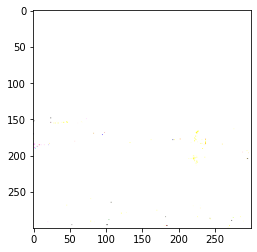

In [35]:
img = tf.image.resize(image, (300,300))
plt.imshow(img)

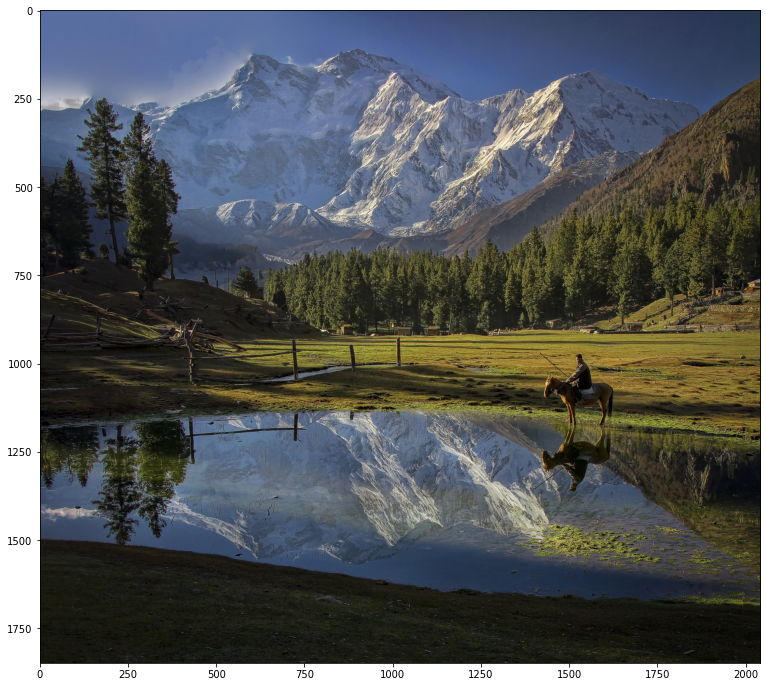

In [39]:
path=str(training_sorted[1])
image=Image.open(path)
plt.figure(figsize=(24, 12))
plt.imshow(image)

In [21]:
img = tf.image.resize(image, (300,300))
print(img)
# plt.imshow(img)

tf.Tensor(
[[[ 90.378     110.378     160.9      ]
  [ 89.406     109.406     160.40599  ]
  [ 89.13      110.        160.       ]
  ...
  [ 39.92       55.92       78.       ]
  [ 38.461998   53.588017   74.462    ]
  [ 39.521942   54.899902   75.52194  ]]

 [[ 91.        111.        161.       ]
  [ 89.7       110.        160.       ]
  [ 89.        111.        161.       ]
  ...
  [ 39.5        54.87       77.87     ]
  [ 40.558014   55.558014   76.558014 ]
  [ 39.100098   54.17417    75.17417  ]]

 [[ 88.9       110.090004  160.9      ]
  [ 88.37      110.37      160.37001  ]
  [ 89.        111.        161.       ]
  ...
  [ 38.6        54.05       77.05     ]
  [ 43.189915   58.159912   81.15991  ]
  [ 38.47017    54.47017    77.47017  ]]

 ...

 [[ 18.569933   21.279957   10.45996  ]
  [ 15.239942   17.23994     5.0699105]
  [ 21.599976   22.599976   14.199951 ]
  ...
  [ 22.350037   22.300049   17.800049 ]
  [ 21.96002    21.029997   16.23007  ]
  [ 15.960093   15.860117    8.15

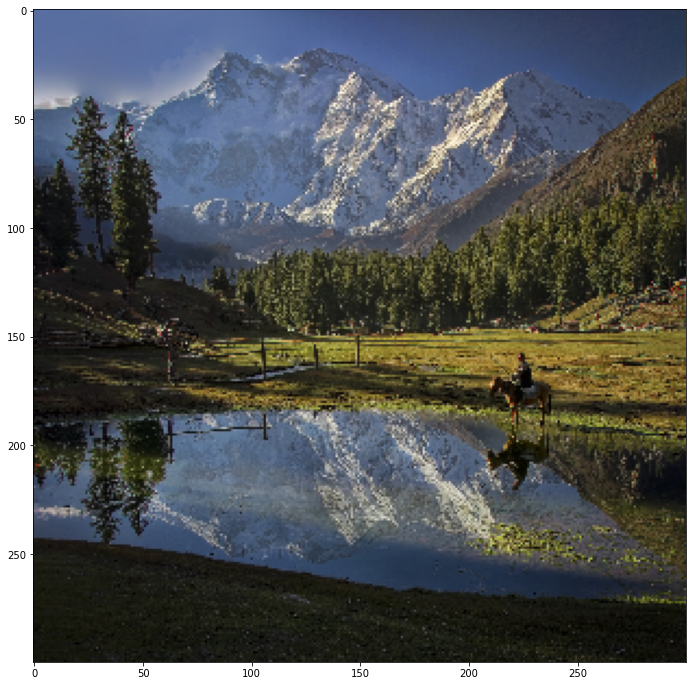

In [22]:
plt.figure(figsize=(24,12))
plt.imshow(img/255)
plt.savefig("1.png")

In [23]:
batched = np.array([img])
batched.shape

(1, 300, 300, 3)

In [24]:
pred = loaded_model.predict(batched)

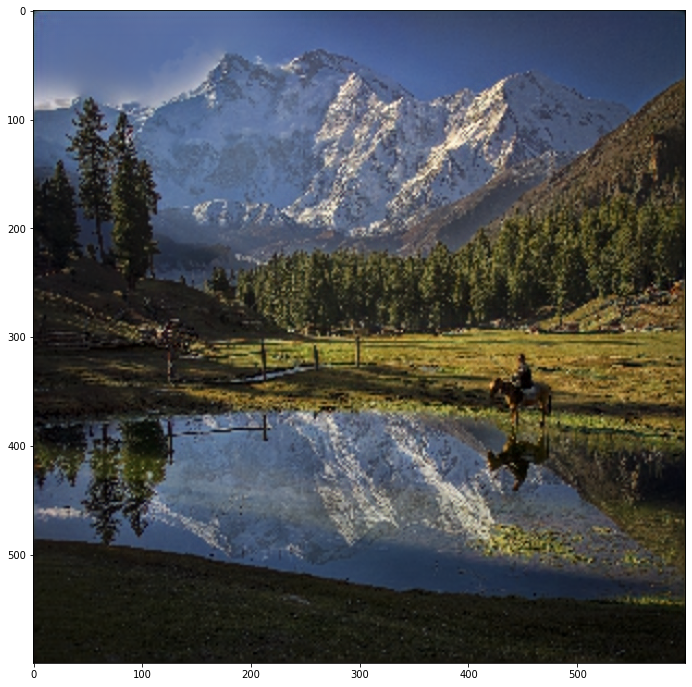

In [25]:
plt.figure(figsize=(24,12))
plt.imshow(pred[0]/255)
plt.savefig("2.png")

In [62]:
ds_test.take(1)

<TakeDataset shapes: ((None, 300, 300, 3), (None, 600, 600, 3)), types: (tf.float32, tf.float32)>

In [74]:
img = tf.image.resize(image, (600,600))
plt.figure(figsize=(24,12))
plt.imshow(img/255)

In [83]:
p = ds_train.take(1)


(2, 300, 300, 3) (2, 600, 600, 3)
(300, 300, 3) (600, 600, 3)


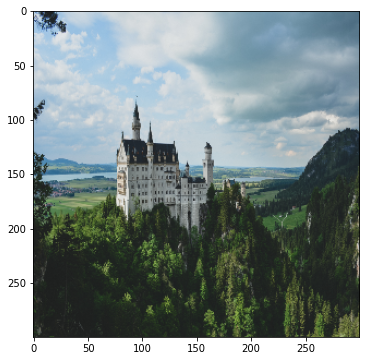

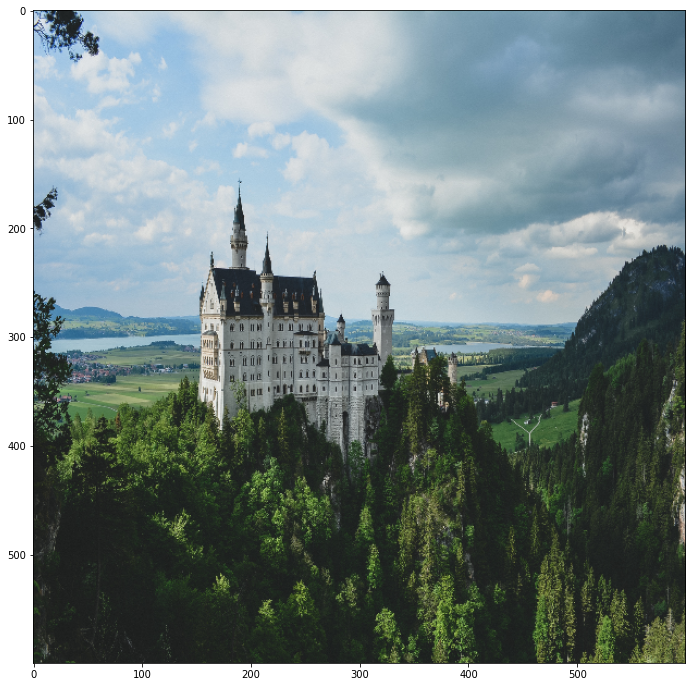

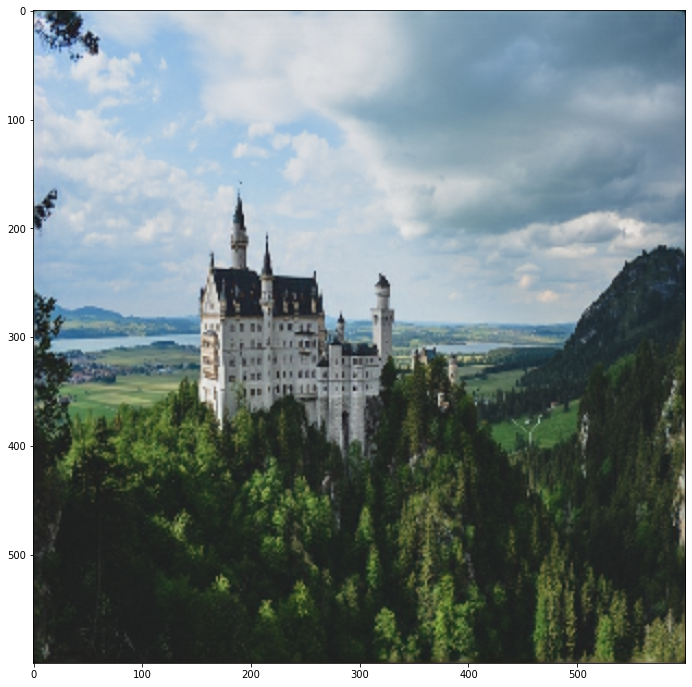

In [28]:
for i,xyz in enumerate(ds_train.take(1)):  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    print(xyz[0].shape, xyz[1].shape)
    hri = xyz[1][i]
    lri = xyz[0][i]
    print(lri.shape, hri.shape)
    batched = np.array([lri])
    pred = loaded_model.predict(batched)
    plt.figure(figsize=(12,6))
    plt.imshow(lri/255)
    plt.savefig("ghatia.png")
    plt.show()
    plt.figure(figsize=(24,12))
    plt.imshow(hri/255)
    plt.savefig("accha.png")
    plt.show()
    plt.figure(figsize=(24,12))
    plt.imshow(pred[0]/255)
    plt.savefig("apna_ghatia.png")
    plt.show()